fraction of significant gauges: 95.81157906949763
average diff of significant gauges: 33.544485941963785
14.23362937471618 23.473205180220152
79.9874059923359 109.04385242130554
fraction of significant gauges: 87.78138779299141
average diff of significant gauges: 6.8938704547052865
-1.4315122534978182 12.152595928566551
26.165592791177414 54.23904282962096


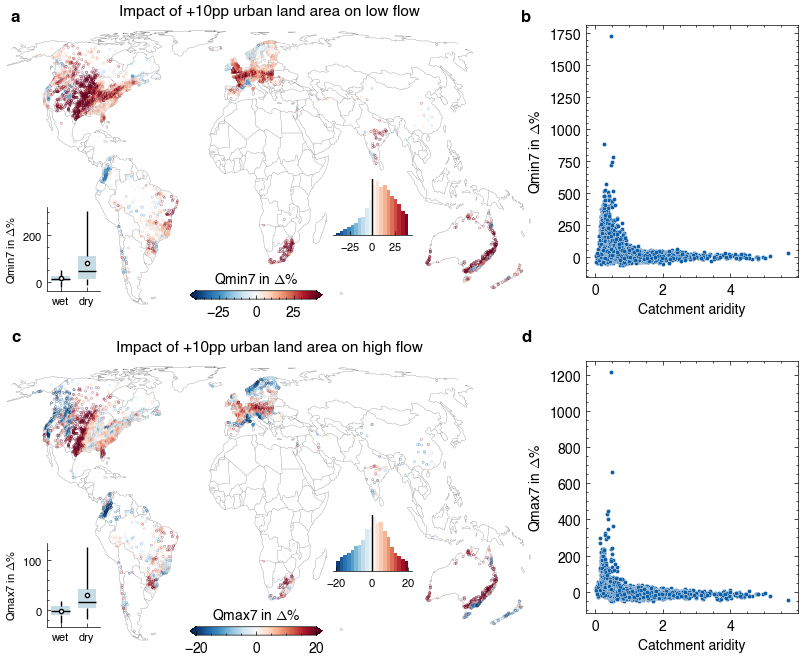

In [1]:
from src.plot_utils import *
from pathlib import Path
import json
from scipy import stats

dir_Qmax7 = Path('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/')
dir_Qmin7 = Path('../results/run_Qmin7_onlyUrban_0506_1357_seed220973/')

Qmin7Fname = '../data/Qmin7_final_dataset_seasonal4.pkl'
Qmax7Fname = '../data/Qmax7_final_dataset_seasonal4.pkl'

par_map = pd.read_csv('../data/predictors.csv')

with open(dir_Qmax7 / 'cfg.json', 'r') as fp:
    cfg = json.load(fp)
    
mode = cfg['mode']
predictors = cfg['meteo_name'] + cfg['lulc_name'] + cfg['attr_name']
log = cfg['log']
m3s = cfg['m3s']
feature = cfg['feature']
model = cfg['model']
featureName = par_map.loc[par_map.par==feature,'name'].values[0]

with open(dir_Qmin7 / 'cfg.json', 'r') as fp:
    cfg_Qmin7 = json.load(fp)
cfg_Qmax7 = cfg

delta_feature = int(cfg_Qmax7['delta_feature'])

Qmin7Fname = dir_Qmin7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'
Qmax7Fname = dir_Qmax7 / f'{model}_{mode}_sensitivity_func_+0{delta_feature}{feature}_diff_in_percentage.csv'

diff_Qmin7 = pd.read_csv(Qmin7Fname)
diff_Qmax7 = pd.read_csv(Qmax7Fname)

diff_Qmin7['Qmin7date'] = pd.to_datetime(diff_Qmin7['Qmin7date'])
diff_Qmax7['Qmax7date'] = pd.to_datetime(diff_Qmax7['Qmax7date'])

diff_Qmin7 = pd.read_pickle(cfg_Qmin7['fname']).merge(diff_Qmin7, on = ['ohdb_id','Qmin7date'])
diff_Qmax7 = pd.read_pickle(cfg_Qmax7['fname']).merge(diff_Qmax7, on = ['ohdb_id','Qmax7date'])

diff_Qmin7_ave = diff_Qmin7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()
diff_Qmax7_ave = diff_Qmax7.groupby(['ohdb_longitude','ohdb_latitude','climate_label','aridity'])['diff'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 8), subplot_kw = {'projection':ccrs.EqualEarth()})
plt.subplots_adjust(hspace = .2)
ax1.set_facecolor('none')
ax2.set_facecolor('none')
for i,name in enumerate(['Qmin7','Qmax7']):
    ax = eval('ax'+str(i+1))
    df = eval('diff_'+name+'_ave')
    lons = df.ohdb_longitude.values
    lats = df.ohdb_latitude.values
    vals = df['diff'].values

    if i == 0:
        vmin, vmax, vind = -40, 40, 4
    else:
        vmin, vmax, vind = -20, 20, 2
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
    if i == 0:
        title = f'Impact of +10pp {featureName.lower()} on low flow'
    else:
        title = f'Impact of +10pp {featureName.lower()} on high flow'
    label = f'{name} in $\Delta$%'
    _, ras = plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, norm = norm, fontSize = 11, size = 3)
    # add colorbar
    cax = ax.inset_axes([.35, .02, 0.25, .03])
    cbar = plt.colorbar(ras, cax = cax, orientation = 'horizontal', extend = 'both')
    cax.tick_params(labelsize = 10)
    cax.set_title(label, size = 10, pad = 5)
    # add boxplot to show the impact for dry (AI<1) and wet (AI>1) catchments
    df['tmp'] = np.where(df['aridity']>0.65, 'wet', 'dry')
    
    ttest = stats.ttest_ind(df.loc[df.tmp=='wet','diff'].values, df.loc[df.tmp=='dry','diff'].values)

    print('fraction of significant gauges:', df.loc[df.p<=0.05,:].shape[0] / df.shape[0] * 100)
    print('average diff of significant gauges:', df.loc[df.p<=0.05,'diff'].mean())
    print(df.loc[df.tmp=='wet','diff'].mean(), df.loc[df.tmp=='wet','diff'].std())
    print(df.loc[df.tmp=='dry','diff'].mean(), df.loc[df.tmp=='dry','diff'].std())
    
    axin = ax.inset_axes([0.08, .05, .1, .3])
    sns.boxplot(df.loc[df.p<=0.01,:], 
                x = 'tmp', y = 'diff', ax = axin, 
                showfliers = False, width = .7, 
                whis = [5, 95],
                color = '#c2dcea',
                showmeans = True,
                capprops = {'linewidth': 0},
                boxprops={'edgecolor': 'none'},  # No edge line
                meanprops={'marker': 'o',
                    'markerfacecolor': 'white',
                    'markeredgecolor': 'black',
                    'markersize': '3'},
                medianprops={'color': 'black', 'linewidth': 1},  # Black median line
                whiskerprops={'color': 'black', 'linewidth': 1},  # Black whiskers
            )
    axin.set_facecolor('none')
#     axin.set_yticks([0,9])
    axin.set_xlabel(None)
    axin.set_ylabel(f'{name} in $\Delta$%', fontsize = 8)
    axin.tick_params(labelsize = 8,  which='both', top = False, right = False)
    axin.xaxis.set_minor_locator(ticker.NullLocator())
    axin.spines["top"].set_visible(False) 
    axin.spines["right"].set_visible(False) 

ax3 = ax1.inset_axes([1.1, .1, .4, .9])
ax4 = ax2.inset_axes([1.1, .1, .4, .9])
for i,name in enumerate(['Qmin7','Qmax7']):
    ax0 = [ax3,ax4][i]
    df0 = eval('diff_'+name+'_ave')
    sns.scatterplot(data = df0, x = 'aridity', y = 'diff', ax = ax0, palette = palette)
    ax0.set_xlabel('Catchment aridity', fontsize = 10)
    ax0.set_ylabel(f'{name} in $\Delta$%', fontsize = 10)
    ax0.tick_params(axis = 'both', labelsize = 10)

# add subplot order
fig.text(.15, .9, 'a', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88, .9, 'b', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.15,  .5, 'c', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)
fig.text(.88,  .5, 'd', weight = 'bold', va = 'top', ha = 'center', fontsize = 12)

fig.savefig(dir_Qmax7 / 'fig2.png', dpi = 600)

In [4]:
!python xgb_flood.py --fname ../data/Qmax7_final_dataset_seasonal4.pkl --mode onlyUrban --purpose sensitivity --run_dir ../results/run_Qmax7_onlyUrban_0506_1359_seed824956/ --delta_feature 10

attr_name: ['BDTICM', 'elevation', 'slope', 'sedimentary', 'plutonic', 'volcanic', 'metamorphic', 'clay', 'sand', 'silt', 'Porosity_x', 'logK_Ice_x', 'year', 'climate', 'season_id', 'basin_id', 'ohdb_latitude', 'ohdb_longitude', 'res_darea_normalize', 'Year_ave', 'Main_Purpose_id', 'form_factor', 'LAI']
delta_feature: 10
device: cpu
even: False
feature: ImperviousSurface
fname: ../data/Qmax7_final_dataset_seasonal4.pkl
gpu: False
iteration: 30
log: True
lulc_name: ['ImperviousSurface']
m3s: False
meteo_name: ['p', 'tmax', 'tmin', 'swd', 'snowmelt', 'smrz']
min_interval: 0
mode: onlyUrban
model: xgb
num_workers: 8
purpose: sensitivity
run_dir: ../results/run_Qmax7_onlyUrban_0506_1359_seed824956
seed: 824956
target: Qmax7
n_iter: 100
n_explain: 100
Finish model fitting


In [5]:
df = pd.read_csv('../results/run_Qmax7_onlyUrban_0506_1359_seed824956/xgb_onlyUrban_sensitivity_func_+010ImperviousSurface_diff_in_percentage.csv')

In [7]:
tmp = pd.read_csv('../data/basin_attributes.csv')
df = df.merge(tmp[['ohdb_id','ohdb_longitude','ohdb_latitude']], on = 'ohdb_id')
df

,ohdb_id,Qmax7date,base,future,diff,ohdb_longitude,ohdb_latitude
0,OHDB_001000004,1981-12-30,8.492106,7.764424,-8.568929,-67.595000,1.074000
1,OHDB_001000004,1982-05-31,11.864690,9.190742,-22.537025,-67.595000,1.074000
2,OHDB_001000004,1982-06-02,12.097580,10.129318,-16.269880,-67.595000,1.074000
3,OHDB_001000004,1982-09-14,6.370955,6.000840,-5.809408,-67.595000,1.074000
4,OHDB_001000004,1982-12-12,7.259428,7.339160,1.098329,-67.595000,1.074000
...,...,...,...,...,...,...,...
1228135,OHDB_016000354,2019-09-01,1.181377,1.243298,5.241478,112.920187,27.857357
1228136,OHDB_016000354,2020-02-22,2.131021,2.145341,0.671951,112.920187,27.857357
1228137,OHDB_016000354,2020-04-06,7.784400,7.118756,-8.550997,112.920187,27.857357
1228138,OHDB_016000354,2020-06-12,10.788311,9.670280,-10.363351,112.920187,27.857357


In [11]:
df1 = df.loc[(df.ohdb_longitude>=-82)&(df.ohdb_longitude<=-65)&(df.ohdb_latitude>=-5)&(df.ohdb_latitude<=12),:]
df1 = df1.groupby(['ohdb_longitude','ohdb_latitude'])['diff'].agg(
    diff = lambda x:x.mean(),
    p = lambda x: stats.ttest_1samp(x, 0, alternative='two-sided').pvalue
).reset_index()
import folium
import branca.colormap as cm
colormap = cm.LinearColormap(
    colors=['blue', 'red'], # Low value to High value colors
    vmin=-10,
    vmax=10,
    caption='Population (Millions)' # Legend title
)
# Create a map centered on the mean of your coordinates
map_center = [df1['ohdb_latitude'].mean(), df1['ohdb_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=4)
# Add scatter points
for index, row in df1.iterrows():
    folium.CircleMarker(
        location=[row['ohdb_latitude'], row['ohdb_longitude']],
        radius=2,  # Adjust radius based on your data
        popup=row['p'],
        color=colormap(row['diff']),
        fill=True,
        fill_color=colormap(row['diff'])
    ).add_to(m)
m

<Axes: xlabel='urban', ylabel='ImperviousSurface'>

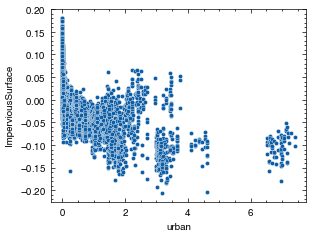

In [14]:
import pickle
fname = '../results/run_Qmax7_onlyUrban_0506_1359_seed824956/xgb_onlyUrban_shap_values_explain_103650.pkl'
shap0 = pickle.load(open(fname,'rb'))
df0 = pd.DataFrame(data = shap0, columns = predictors)
tmp = pd.read_pickle(cfg_Qmax7['fname']).rename(columns={'ohdb_longitude':'lon','ohdb_latitude':'lat','ImperviousSurface':'urban'})
df0 = pd.concat([df0, tmp[['ohdb_id','lon','lat','urban']]], axis = 1)
df0 = df0.loc[(df0.lon>=-82)&(df0.lon<=-65)&(df0.lat>=-5)&(df0.lat<=12),:]
sns.scatterplot(df0, x = 'urban', y = 'ImperviousSurface')

In [28]:
df0 = pd.read_pickle(cfg_Qmax7['fname'])
df0 = df0.loc[(df0.ohdb_longitude>=-82)&(df0.ohdb_longitude<=-65)&(df0.ohdb_latitude>=-5)&(df0.ohdb_latitude<=12),:]
X = df0[predictors]
y = np.log((df0['Q']+0.1)/df0['gritDarea'] * 86.4)
# load saved model
import xgboost as xgb

cate_attr = []
feature_types = X.agg(lambda x: 'q').to_dict()
for a in ['climate', 'season_id', 'Main_Purpose_id', 'basin_id', 'gauge_id', 'koppen_id', 'year']:
    if a in predictors:
        cate_attr.append(a)
        feature_types[a] = 'c'
        X[a] = X[a].astype(np.int16)
feature_types = list(feature_types.values())

# exhaustively search for the optimal hyperparameters
cfg = cfg_Qmax7
ml=xgb.XGBRegressor(
    eval_metric='rmsle', 
    tree_method="hist", 
    device='cpu', 
    # objective = my_assymetric_error_wrapper(tau = 0, delta = 9),
    enable_categorical = True,
    feature_types = feature_types,
)

# set up our search grid
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 500, 800, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

model = cfg["model"]
mode = cfg['mode']

from sklearn.model_selection import cross_val_predict, train_test_split, RandomizedSearchCV, KFold
# try out every combination of the above values
cv = KFold(n_splits = 3, shuffle = True)
random_search = RandomizedSearchCV(
    ml, 
    param_distributions = param_dist, 
    n_iter = 10, 
    cv = cv, 
    verbose = 5, 
    n_jobs = 3
)
random_search.fit(X, y)

ml = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [33]:
X = df0[predictors]
ml.fit(X, y)
base = ml.predict(X)
X['ImperviousSurface'] = X['ImperviousSurface'] + 10
pred = ml.predict(X)
diff = (np.exp(pred) - np.exp(base)) / np.exp(base) * 100
df0['diff'] = diff
df0['Qmax7date'] = pd.to_datetime(df0['Qmax7date'])
import pymannkendall as mk

df1 = df0.groupby(['ohdb_longitude','ohdb_latitude']).apply(lambda x: pd.Series([
    mk.original_test(x.sort_values('Qmax7date').Q.values/x.sort_values('Qmax7date').gritDarea.values).slope,
    x['diff'].mean(),
    stats.ttest_1samp(x['diff'].values, 0, alternative='two-sided').pvalue
], index = ['trend','diff','p'])).reset_index()


In [37]:
import folium
import branca.colormap as cm
colormap = cm.LinearColormap(
    colors=['blue', 'red'], # Low value to High value colors
    vmin=-1,
    vmax=1,
    caption='Population (Millions)' # Legend title
)
# Create a map centered on the mean of your coordinates
map_center = [df1['ohdb_latitude'].mean(), df1['ohdb_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=4)
# Add scatter points
for index, row in df1.iterrows():
    folium.CircleMarker(
        location=[row['ohdb_latitude'], row['ohdb_longitude']],
        radius=2,  # Adjust radius based on your data
        popup=row['p'],
        color=colormap(row['trend']),
        fill=True,
        fill_color=colormap(row['diff'])
    ).add_to(m)
m


<Axes: >

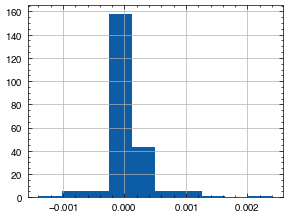

In [38]:
df1.trend.hist()

In [39]:
X.describe()

,p,tmax,tmin,swd,snowmelt,smrz,ImperviousSurface,BDTICM,elevation,slope,...,climate,season_id,basin_id,ohdb_latitude,ohdb_longitude,res_darea_normalize,Year_ave,Main_Purpose_id,form_factor,LAI
count,27097.000000,27097.000000,27097.000000,27097.000000,2.709700e+04,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,...,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000,27097.000000
mean,8.116805,21.984244,15.479650,173.562072,4.361390e-08,0.435105,10.239233,10.201266,1660.519903,5.909810,...,1.533638,1.517917,64.731299,4.681064,-74.583403,0.015573,2017.615488,0.347086,0.024629,2.921263
std,4.711836,4.717023,4.916243,29.607467,7.179357e-06,0.037892,0.587267,2.984230,958.400274,3.120746,...,0.884611,1.113164,24.498334,2.559312,2.053282,0.076689,15.782722,0.907288,0.008082,1.021356
min,0.000000,9.955714,4.118571,63.123114,0.000000e+00,0.156361,10.000000,4.800000,39.985117,0.127904,...,1.000000,0.000000,0.000000,-4.340800,-78.966389,0.000000,1957.000000,0.000000,0.008145,1.003095
25%,5.111429,18.276479,11.552553,153.460976,0.000000e+00,0.417990,10.002757,8.191000,829.430670,3.806533,...,1.000000,1.000000,74.000000,2.970000,-75.899250,0.000000,2024.000000,0.000000,0.019168,2.248140
50%,7.296171,21.701429,15.097710,173.397073,0.000000e+00,0.439947,10.034747,9.886000,1738.651520,6.246668,...,1.000000,2.000000,76.000000,4.892500,-74.894861,0.000000,2024.000000,0.000000,0.024363,2.722332
75%,10.002640,25.525714,19.234286,193.426851,0.000000e+00,0.454816,10.175732,11.789000,2442.762503,8.234060,...,3.000000,3.000000,76.000000,6.285000,-73.306944,0.000000,2024.000000,0.000000,0.030244,3.282435
max,71.754155,38.014605,28.424448,292.364201,1.181806e-03,0.525773,17.405342,23.589000,3454.060350,13.957394,...,3.000000,3.000000,77.000000,11.277639,-67.595000,0.956724,2024.000000,6.000000,0.047236,5.692874
